# IN3050/IN4050 2025: Week 04 Classification by *k*NN
## Introduction
The goal of this week is to get a first experience with supervised classification.
In particular, we will get familiar with how to set up, run and evaluate experiments.
We will also implement the *k*NN-algorithm using pure Python.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## Dataset
To do machine learning, we need data.
To make it simple, we use scikit-learn to construct a synthetic dataset with
- 2 classes
- 2 numerical features
- 200 items

We will use `X`-s for the input values and `t`-s for the target values. Since we will be using pure Python in this exercise set, we transform the data from numpy arrays, like `X_np`, to lists, like `X1`.

Don't worry about the magic recipe for how we cook the data for now!

In [42]:
from sklearn.datasets import make_blobs
X_np, t_np = make_blobs(n_samples=200, centers=[[0,0],[1,2]], 
                  n_features=2, random_state=2024)
X1 = [(X_np[i,0], X_np[i,1]) for i in range(X_np.shape[0])]
t1 = [t_np[i] for i in range(X_np.shape[0])]

This is a general form for representing data we will use a lot in this course. We store the features in one list and the labels in another list of the same length. For example, y[14] is the label the dataset ascribes to the input X[14], where X[14] is a pair (two-tuple) of numbers.

(Later on we will use numpy arrays and not lists, e.g., the X_np, t_np, above.)

We can then take a look at the training set using scatterplot.

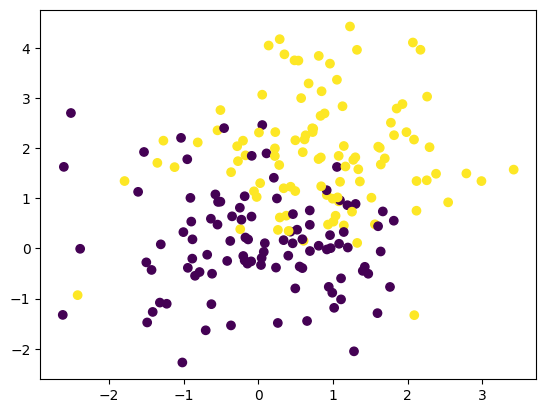

In [43]:
plt.scatter(X_np[:, 0], X_np[:, 1], c=t_np)

To add a legend (i.e., naming the classes) we sort the data into the two classes before plotting. We may then use the `plot` command.

In [44]:
def show(X, y, marker='.'):
    labels = set(y)
    cl = {lab : [] for lab in labels}
    # cl[lab] shall contain the datapoints labeled lab
    for (a, b) in zip(X, y):
        cl[b].append(a)
    for lab in labels:
        plt.plot([a[0] for a in cl[lab]], [a[1] for a in cl[lab]], 
                 marker, label="class {}".format(lab))
    plt.legend()

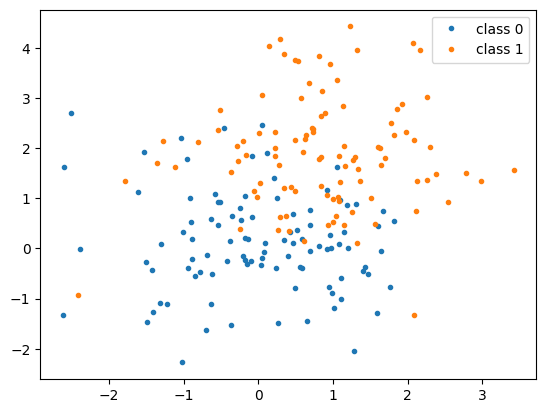

In [45]:
show(X1, t1)

## *k*NN
We will now implement the *k*NN algorithm.
We first need to calculate the distance between two points.

There are, of course, methods, e.g. in numpy, that are more than willing to do this for us. But we are here to learn. So we implement it ourselves.

### Exercise I: Distance
Implement a (L2-) distance function. It should work for points in *n*-dimensional space for any integer *n*>0. Check that dist((3,4,0),(0,0,12)) is 13.

In [46]:
def dist_proc(a, b):
    # Euclidean distance in a procedural way
    s = 0
    for (x,y) in zip(a,b):
        s += (x - y) ** 2
    return s ** 0.5

In [47]:
dist_proc((3,4,0),(0,0,12)) #=13


13.0

In [48]:
assert dist_proc((3,4,0),(0,0,12)) == 13

### Exercise II: Majority class
The next thing we need is a way to determine the majority class from a set of votes. Implement a procedure which takes a list as argument and returns the majority class. 

In [49]:
def majority(a):
    """Return the majority class of a
    
    For example majority([0,1,1,1,0]) should return 1"""
    list = Counter(a)
    return list.most_common(1)[0][0]

    

#### Hint: Counter
For this we can use the Counter method. If you are not familiar with Counter, experiment with it to see how it works.

In [50]:
from collections import Counter
print("Example")
s = ['a', 'b', 'c', 'b', 'c']
counts = Counter(s)
print(s)
print(counts)
print(counts.most_common())

Example
['a', 'b', 'c', 'b', 'c']
Counter({'b': 2, 'c': 2, 'a': 1})
[('b', 2), ('c', 2), ('a', 1)]


### Exercise III: the *k*NN algorithm
We will use a class for implementing the classifier. We have chosen a format that we can later reuse for various other classifier algorithms. The format is inspired by scikit-learn. We will have a superclass where we can put methods common to the various classification algorithms.

The class will have three methods; one `init` where we set the hyperparameters, one `fit` where the training takes place, and one `predict` which predicts the class of a list of new items after we have trained the classifier.

The training will have the form
```python
cls = PykNNClassifier(k=5) # OR some other number, default 3
cls.fit(X_train, t_train)
```

We can then classify a new item by e.g.
```python
p = (1,1)
cls.predict([p])
```

Implement the `predict` method.

In [51]:
class PyClassifier():
    """Common methods to all python classifiers --- if any
    
    Nothing here yet"""
    def __init__(self):
        """Initialize classifier"""
        self.trained = False
        self.classes_ = None
        self.features_importance = None
    
    def predict(self,X):
        if not self.trained:
            raise RuntimeError("Classifier not trained")
        raise NotImplementedError("Subclasses should implement this")

    def score(self,X,t):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        return{}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def __repr__(self):
         return f"{self.__class__.__name__}()"
    

In [52]:
class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, t_train):
        self.X_train = X_train
        self.t_train = t_train
    
    def predict(self, a):
        """Predict class labels for input points"""
        predictions = []
        for point in a:
            # Calculate distances to all training points
            distances = [(self.dist(point, x), t) for x, t in zip(self.X_train, self.t_train)]
            # Sort by distance and get k nearest
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            # Get the labels of k nearest points
            k_labels = [label for _, label in k_nearest]
            # Predict using majority vote
            predictions.append(majority(k_labels))
        return predictions
    
# Create sample data
X_train = [[1, 1], [1, 2], [2, 1], [5, 5], [5, 6], [6, 5]]
t_train = [0, 0, 0, 1, 1, 1]

# Create and train classifier
clf = PykNNClassifier(k=3)
clf.fit(X_train, t_train)

# Test predictions
test_points = [[1.5, 1.5], [5.5, 5.5]]
print(clf.predict(test_points))  # Should print [0, 1]

[0, 1]


## Experiments and evaluation
To check how good the classifier is, we cannot consider singular datapoints. 
We have to see how the classifier performs on a larger test set.
With our synthetic training data, we can make a test set in a similar way.

We follow the same recipe as for the training set, but observe that we use a different *random_state* to get a set different from the training set.

In [60]:
X_np, t_np = make_blobs(n_samples=200, centers=[[0,0],[1,2]], 
                  n_features=2, random_state=2020)
X2 = [(X_np[i,0], X_np[i,1]) for i in range(X_np.shape[0])]
t2 = [t_np[i] for i in range(X_np.shape[0])]

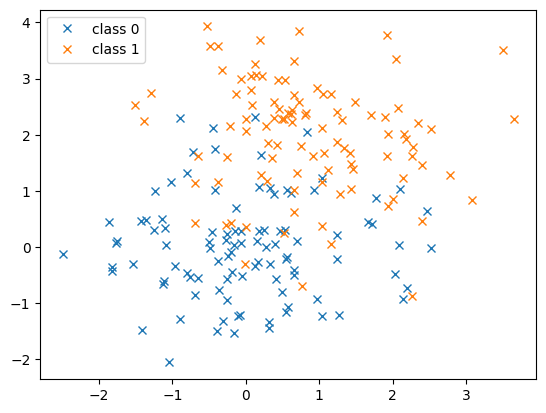

In [57]:
show(X2, t2, 'x')

### Exercise IV: Accuracy
There are several different evaluation measures that can be used, and we will see a couple of them the coming weeks. For today, we only consider the simple *accuracy*, the proportion of items classified correctly.

Implement a function `accuracy()`. It should take two arguments, where each is a list of labels and compare the two and return a numerical value for the accuracy. We will apply it to measure the accuracy of the classifier `cls` as follows:

```python
accuracy(cls.predict(X_test), t_test)
```

Test it on X2, t2 when trained on X1, t1 for various values of *k*.
Let *k* be any odd integer below 20. Plot the results.

Beware that there is no *k* which is the best for all datasets. It varies with the dataset. To decide on the best *k* for a specific dataset, we should use a separate development test set to determine the best *k*. Then we fix this *k* and test on the final test set. 

In [61]:
def accuracy(y,t):
     """Calculate the accuracy"""
     equal = len([(p, g) for (p,g) in zip(y, t) if p==g])
     return equal / len(t)

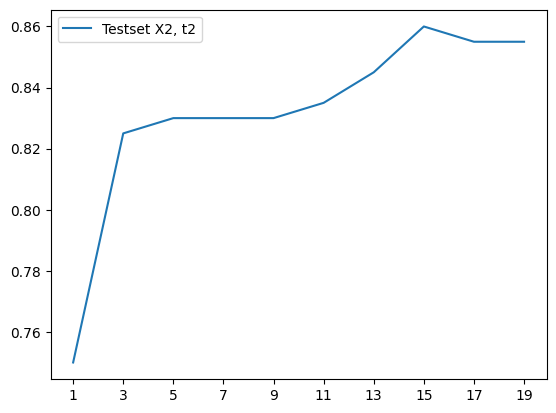

In [62]:
x = range(1, 20, 2)
accuracies = []
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X1, t1)
    accuracies.append(accuracy(cls.predict(X2), t2))
plt.plot(x, accuracies, label="Testset X2, t2")
plt.xticks(x)
plt.legend()

### Exercise V: Variation

One should be cautious drawing too strong conclusions from an experiment like this. Check whether you get the same result with a different random test set drawn from the same distribution.

In [69]:
X_np, t_np = make_blobs(n_samples=200, centers=[[0,0],[1,2]], 
                  n_features=2, random_state=2021)
X3 = [(X_np[i,0], X_np[i,1]) for i in range(X_np.shape[0])]
t3 = [t_np[i] for i in range(X_np.shape[0])]
                        

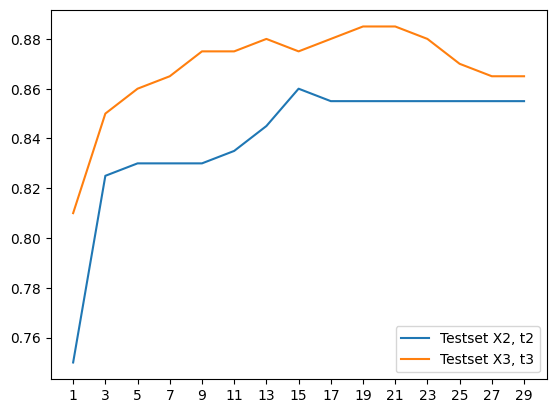

In [70]:
x = range(1, 30, 2)
accuracies2 = []
accuracies3 = []
for k in x:
    cls = PykNNClassifier(k=k)
    cls.fit(X1, t1)
    accuracies2.append(accuracy(cls.predict(X2), t2))
    accuracies3.append(accuracy(cls.predict(X3), t3))
plt.plot(x, accuracies2, label="Testset X2, t2")
plt.plot(x, accuracies3, label="Testset X3, t3")
plt.xticks(x)
plt.legend()

In [71]:
accuracies2[-1]

0.855

### Exercise VI: Confusion matrix

Implement a procedure for calculating a confusion matrix for a classifier and try it on one of the runs above

In [65]:
def cf_matrix(predicted, gold):
    table = np.zeros((2,2))
    for p,g in zip(predicted, gold):
        table[int(p), g] +=1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|".format(" ","neg", "pos"))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","neg",table[0,0], table[0,1]))
    print("predicted "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","pos",table[1,0], table[1,1]))
    print(10*" "+30*"-")

In [66]:
cls = PykNNClassifier(k=5)
cls.fit(X1,t1)
cf_matrix(cls.predict(X2), t2)

                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |     82.0|     16.0|
predicted ------------------------------
          pos       |     18.0|     84.0|
          ------------------------------
